<a href="https://colab.research.google.com/github/Denbergvanthijs/hu-reinforcement-learning-gym/blob/master/2_Hogeschool_Utrecht_Reinforcement_Learning_project_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning project - Deep Q-Learning


## Aim
Time to up our [OpenAI Gym](https://gym.openai.com/) game with some [Atari Space Invaders](https://gym.openai.com/envs/SpaceInvaders-v0/) (or another [supported Atari game](https://gym.openai.com/envs/#atari)!). Q-Learning won't cut it this time. Let's take out the DQNs and beat this game!

## Runtime and environment
This [Jupyter Notebook](https://jupyterlab.readthedocs.io/en/latest/) was made to run on Google Colab. For this training, we recommend using the Google Colab environment.

Please read the [instructions on Google Colab](https://medium.com/swlh/the-best-place-to-get-started-with-ai-google-colab-tutorial-for-beginners-715e64bb603b) to get started quickly. It behaves similar to Jupyter Notebook, Jupyter Hub and Jupyter Lab, so if you have any experience with those, you're good to go!

Some notes on Google Colab:
- **Processes in Google Colab won't run forever**. These may be terminated at any time when the platform is crowded, and *will definitely* terminate after 12 hours. To maintain persistency, you can attach the session to **Google Drive** and have your models persist themselves to the Google Drive periodically.
- You can enable GPU or TPU support! You can find this option under *Runtime* -> *Change runtime type*.
- After installing dependencies, you need to restart the runtime in order to actually use them.

If you want to run the code on your own platform or system, you need to keep a few things in mind:
- The dependencies you need to install may differ from the ones we installed here. The installed dependencies are suitable for Google Colab, Ubuntu, and Debian.
- Since Google Colab isn't attached to a monitor, we render the output to a video file. On your own machine the built-in render method from OpenAI's Gym may suffice.
- The default paths use Google Drive! Change these.

## Info Support
This assignment was developed by Info Support. Looking for a graduation project or job? Check out their website: https://carriere.infosupport.com/




# Preparation

Some dependencies need to be installed for the code to work. Furthermore, we will define some methods which allow us to show the OpenAI Gym renderings in this (headless) Google Colab environment.

In [1]:
# Install dependencies
"""Note: if you are running this code on your own machine, you probably don't need all of these.
   Start with 'pip install gym' and install more packages if you run into errors."""
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg cmake > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install atari-py > /dev/null 2>&1
!pip install torchagent > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.2.0)


In [2]:
# Imports for helper functions
import base64
import copy
import io
import math
from pathlib import Path

import gym
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
from gym.wrappers import Monitor
from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display

In [3]:
# Mount your Google Drive. By doing so, you can store any output, models, videos, and images persistently.
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Create a directory to store the data for this lab. Feel free to change this.
data_path = Path('/content/gdrive/My Drive/Colab Notebooks/HU_RL/part2')
data_path.mkdir(parents=True, exist_ok=True)
video_path = data_path / 'video'

In [5]:
# Define helper functions to visually show what the models are doing.
%matplotlib inline

gym.logger.set_level(gym.logger.ERROR)

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    # Display the stored video file
    # Credits: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
    mp4list = list(data_path.glob('video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print('Could not find video')


def record_episode(idx):
    # This determines which episodes to record.
    # Since the video rendering in the OpenAI Gym is a bit buggy, we simply override it and decide
    # whether or not to render inside of our training loop.
    return True

    
def video_env(env):
    # Wraps the environment to write its output to a video file
    env = Monitor(env, video_path, video_callable=record_episode, force=True)
    return env


# Test the environment

In [6]:
"""Let's check out the Space Invaders environment"""

# Create the desired environment
env = gym.make("SpaceInvaders-v0")

# Wrap the environment, to make sure we get to see a fancy video
env = video_env(env)

# Before you can use a Gym environment, it needs to be reset.
state = env.reset()

# Perform random actions untill we lose (or win).
done = False
while not done:
    env.render()
    # The action_space contains all possible actions we can take.
    random_action = env.action_space.sample() 

    state, reward, done, info = env.step(random_action)

# Show the results!
env.close()
show_video()

# So... this works exactly the same as with the previous environments! The only differences are the state space and possible actions.

In [7]:
# We have 210 rows, each 160 pixels wide, and each pixel having an RGB value.
# The range of each pixel is 0-255

print('State:', state.shape, state.dtype, state.min(), state.max())

State: (210, 160, 3) uint8 0 181


# Setup


In [8]:
# Imports
import random
from itertools import count

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchagent.memory import SequentialMemory, Transition
from torchagent.policy import DecayingEpsilonGreedyPolicy, EpsilonGreedyPolicy, GreedyPolicy

In [9]:
# Setup GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Wrappers

In [10]:
class ResizeWrapper(gym.ObservationWrapper):
    # This wrapper resizes and normalizes the input images.
    # Feel free to update it! :-)

    def __init__(self, env):
        super(ResizeWrapper, self).__init__(env)
    
    def observation(self, observation):
        # Resize the image by taking every second pixel
        # This reduces the image size from 160x210 to 80x105
        # So 105 rows, of 80 pixels each, having 3 RGB values per pixel
        # img = observation[::2, ::2]
        img = observation[30:-15, 20:-20]
        

        # You can optionally crop the image, to remove irrelevant parts.
        # For example, do you really need to top and bottom parts of the screen?
        # img = ...

        # Convert the image to greyscale
        # img = img.mean(axis=2)
        img = np.dot(img[...,:3], (0.2989, 0.5870, 0.1140))  # Based on https://en.wikipedia.org/wiki/Grayscale

        # Next we normalize the image from -1 to +1
        # img = (img - 128) / 128 - 1
        img = img / 255

        # Did you crop the image? Don't forget to update these dimensions
        # return img.reshape(105, 80, 1)
        return img[..., np.newaxis]

class TorchWrapper(gym.ObservationWrapper):
    # You don't need to worry about this block of code. It should just work.
    def __init__(self, env):
        super(TorchWrapper, self).__init__(env)

    def observation(self, observation):
        output = np.rollaxis(observation, 2, 0)
        output = output.reshape(-1, output.shape[0], output.shape[1], output.shape[2]).astype(np.float32)

        return torch.from_numpy(output).to(device)


(165, 120, 1) 0.0 0.5233874509803921


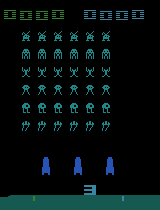

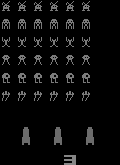

In [18]:
from google.colab.patches import cv2_imshow

test_env = gym.make('SpaceInvaders-v0')
test_state = test_env.reset()

test_resize_wrapper = ResizeWrapper(test_env)
processed_state  = test_resize_wrapper.observation(test_state)
print(processed_state.shape, processed_state.min(), processed_state.max())

cv2_imshow(test_state)
cv2_imshow(processed_state * 255)  # Times 255 to show greyscale

# Environment creation

In [12]:
def create_environment(name='SpaceInvaders-v0'):
    # A shorthand to create a new environment with all of the required wrappers
    env = gym.make(name)
    env = ResizeWrapper(env)
    env = TorchWrapper(env)
    env = video_env(env)
    return env

# DQN Agent

In [13]:
class DQNAgent:
    """
    An implementation of an agent that uses Deep Q-Learning.

    It uses the DQN class, defined further down below, to make decisions for its next move.
    """

    def __init__(self, num_actions, model, loss, optimizer,
                 memory, policy=None, test_policy=None,
                 training=True, enable_dqn=False, batch_size=32,
                 gamma=0.9, tau=1e-3, warmup_steps=0, update_steps=1):
        """
        Initializes a new instance of a Deep Q-Learning agent.
        Parameters:
            num_actions (int): The number of actions that is supported
            model (object): The neural network that is used to calculate the q-values for the agent
            loss (object): The loss function to use for optimizing the agent
            optimizer (object): The optimizer to use for optimizing the agent
            memory (object): The experience buffer to use for the agent
            policy (object): The policy network to use for the agent
            test_policy (object): The target policy network to use for the agent
            training (boolean): Flag indicating the agent is training
            enable_dqn (boolean): Flag enabling double-q value learning
            batch_size (int): The number of samples to use for each cycle of training
            gamma (float): The discount factor for rewards the agent receives
            tau (float): Factor controlling the speed at which the target model is updated
            warmup_steps (int): The number of warmup steps before starting to update the target network
        """

        self.policy = policy if policy is not None else EpsilonGreedyPolicy(num_actions)
        self.test_policy = test_policy if test_policy is not None else GreedyPolicy(num_actions)
        self.memory = memory
        self.training = training
        self.batch_size = batch_size
        self.model = model
        self.target_model = copy.deepcopy(model)
        self.enable_dqn = enable_dqn
        self.num_actions = num_actions
        self.loss = loss
        self.gamma = gamma
        self.optimizer = optimizer
        self.tau = tau
        self.step = 0
        self.warmup_steps = 0
        self.update_steps = 4

    def record(self, state, action, next_state, reward, done):
        """
        Records experience for the agent
        Parameters:
            state (object): The current state
            action (object): The action that was performed
            next_state (object): The next state
            reward (object): The received reward
            done (boolean): Flag indicating the episode was completed
        """
        self.memory.append(state, action, next_state, reward, done)

    def act(self, observation):
        """
        Allows the agent to perform a step based on the provided observation of the environment.
        Parameters:
            observation (object): The observation for the agent to base its decision on.
        Returns:
            int: The index of the selected action
        """

        # First, calculate the q-values for the action space that the agent supports
        # Next, use the training or test policy to predict the next action to take
        with torch.no_grad():
            action_tensor = self.model(observation)

        if self.training:
            selected_action = self.policy.select_action(action_tensor, step=self.step)
        else:
            selected_action = self.test_policy.select_action(action_tensor, step=self.step)

        return selected_action

    def train(self):
        """
        Performs a single training pass using the agent's memory as input.
        """
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*batch))

        self.step += 1

        self.train_model_(batch)
        self.update_target_model_()

    def train_model_(self, batch):
        if self.step < self.warmup_steps or self.step % self.update_steps > 0:
            return

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        terminated_batch = torch.tensor(
            [1. if s == False else 0. for s in batch.done], device=device, dtype=torch.float)

        # We're trying to minimize a loss that is defined as follows:
        # loss = sum(sqr(reward + gamma * target_Q(next_state) - Q(state)))
        #
        # Please note that you can use the huber loss also, but it uses the same inputs:
        # - Q(next_state, a) --> Q-values for the target state
        # - Q(state, a) --> Q-values for the current state
        #
        # We're using a second network to calculate the Q-values for the target state.
        # this stabalizes the training process so it becomes more predictable.
        
        if not self.enable_dqn:
            q_values = self.model(state_batch)
            q_values = q_values.gather(1, action_batch)

            target_q_values = self.target_model(next_state_batch)
            target_q_values = target_q_values.gather(1, action_batch)
        else:
            # In double-q learning we use the policy network to predict the actions instead of using the actually performed actions.
            # We then use these predicted actions to calculate the expected value of these actions.
            q_values = self.model(state_batch)
            estimated_actions = q_values.max(1)[1]

            target_q_values = self.target_model(next_state_batch)
            target_q_values = target_q_values.gather(1, estimated_actions)

        # Calculate the discounted award for the actions taken by the agent.
        # Then reset the reward for the actions that caused the episode to end.
        discounted_reward = self.gamma * target_q_values
        discounted_reward = terminated_batch * discounted_reward

        # Calculate the expected reward using the discounted reward and the actual reward.
        targets = discounted_reward + reward_batch
        targets = targets.detach()

        loss_value = self.loss(q_values, targets.unsqueeze(1))

        # Finally, optimize the policy using the choosen optimizer.
        self.optimizer.zero_grad()
        loss_value.backward()

        for param in self.model.parameters():
            param.grad.data.clamp(-1, 1)

        self.optimizer.step()

    def update_target_model_(self):
        if self.step < self.warmup_steps:
            return

        if self.tau < 1.:
            for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - self.tau) +
                    param.data + self.tau
                )
        else:
            if self.step % self.tau == 0:
                self.target_model.load_state_dict(self.model.state_dict())

# DQN - Network to estimate Q-values

In [14]:
class DQN(nn.Module):
    """ 
    This is the network used by the agent to take a decision on its next action.
    """
    def __init__(self, h, w, channels, outputs):
        """
        Initializes a new instance of DQN
        Parameters:
            h (int): The height of the input screen
            w (int): The width of the input screen
            channels (int): The number of channels in the input screen
            outputs (int): The number of actions to choose from
        """
        super(DQN, self).__init__()

        def conv_output_size(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        # Each conv2D layer resizes the input as calculated in the formula above.
        # Since we're stacking layers, we need to stack the output size calculation as well.
        features_w = conv_output_size(conv_output_size(conv_output_size(w, 8, 4), 4, 2), 3, 1)
        features_h = conv_output_size(conv_output_size(conv_output_size(h, 8, 4), 4, 2), 3, 1)

        self.conv1 = nn.Conv2d(channels, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc = nn.Linear(features_w*features_h*64, 512)
        self.output = nn.Linear(512, outputs)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        """
        Performs the forward pass through the neural network
        Parameters:
            x (tensor): The input tensor for the policy network
        """
        y = self.relu1(self.conv1(x))
        y = self.relu2(self.conv2(y))
        y = self.relu3(self.conv3(y))
        
        # Flatten the output of the convolutional layer.
        # This is required to match the shape with the linear layer.
        y = y.view(y.size(0), -1)

        y = self.relu4(self.fc(y))
        y = self.output(y)

        return y

# Training

Here we start the actual training process.

In [15]:
env = create_environment()
model = DQN(120, 165, 1, env.action_space.n).to(device)  # Don't forget to update these values after resizing or normalizing the images!

loss = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00025)
memory = SequentialMemory(1000000)

num_episodes = 10
num_episodes_between_videos = 50

# Define an agent that uses the experience buffer and value-function model that we created before.
# The agent will try to optimize the value-function to estimate the value of each possible state/action pair.
#
# The agent uses a decaying epsilon-greedy policy to determine the action to execute in the environment.
# We're moving from 100% random to 0.1% chance of random actions in 1M steps. 
# This means, we'll be totally random at the start and slowly moving towards a deterministic policy.
# 
# Note on the gamma parameter: this controls the discount of future rewards when it comes to estimating
# the value-function. A reward received from the current action accounts for 100% of the value of an action
# in the current state. Any possible action in the next state only contributes 99% of its reward towards the
# value in the current state!
# 
# Note on the tau parameter: this controls the speed at which we update the value-function network in the agent.
# We're using a pair of neural networks in the agent to help with the optimization process for the value-function.
# Setting a tau value larger than 1 means that the target network only gets updated after x steps. A value of less
# then 1 means that we're gradually updating the target network.
# The target network construct is important, because it allows us to more predictably learn the value-function.
agent = DQNAgent(env.action_space.n, model, loss, 
    optimizer, memory, tau=10000, gamma=0.99, warmup_steps=50000, update_steps=3,
    policy=DecayingEpsilonGreedyPolicy(env.action_space.n, 1.0, 1000000, 0.1, 1.0))

episodes = []

# We're going to play 100 (= num_episodes) games of space invaders.
# This will take a very long time! Using a GPU or TPU is advised.
# Note that both are available through Google Colab.
for i in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # Run the episode in terms of timesteps (t)
    # This is where the bot actually plays the game
    for t in count():
        if (i + 1) % num_episodes_between_videos == 0:
            env.render()

        # Choose an action and perform it on the environment.
        # The output is a new state, the reward and termination condition.
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        episode_reward += reward

        reward = torch.tensor([reward], device=device)

        # Record the experience with the agent and train the agent.
        # This performs a single backward step through the neural network
        # using a number of previous state/action combinations to find
        # a better value-estimation function.
        agent.record(state, action, next_state, reward, done)
        agent.train()

        # Store the new state as the current state 
        # and move on to the next step if we haven't reached the termination point.
        state = next_state

        if done:
            print('Episode %i finished in %i timesteps with reward %f' % (i, t, episode_reward))
            break

env.close()
show_video()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0 finished in 732 timesteps with reward 135.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 1 finished in 736 timesteps with reward 120.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 2 finished in 511 timesteps with reward 65.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 3 finished in 642 timesteps with reward 55.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 4 finished in 843 timesteps with reward 225.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 5 finished in 844 timesteps with reward 210.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 6 finished in 801 timesteps with reward 210.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 7 finished in 871 timesteps with reward 430.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 8 finished in 506 timesteps with reward 50.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 9 finished in 869 timesteps with reward 150.000000
